# Concave Pro-Rata Games Transient Simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

## Uniswap V2 Forward Exchange Function Sims

In [2]:
# Define UniV2 parameters
GAMMA = 0.99
RESERVES = [200, 250]
EXTERNAL_PRICE = 1

# W is a non-trivial zero of the UniV2 forward exchange function
W = RESERVES[1]/EXTERNAL_PRICE - RESERVES[0]/GAMMA

In [3]:
# Compute the UniV2 equilibrium as the root of a quadratic
def uniV2_equilibrium(num_players, fee=GAMMA,
    reserves=RESERVES, price=EXTERNAL_PRICE):
    
    a = num_players * price * (fee ** 2)
    b = fee ** 2 * reserves[1]
    b += 2 * num_players * price * reserves[0] * fee
    b -= fee ** 2 * num_players * reserves[1]
    c = num_players * reserves[0] * (reserves[0] * price - reserves[1] * fee)
    
    q = np.amax(np.roots([a, b, c]))
    assert q > 0
    
    return q / num_players

In [4]:
# Compute the UniV2 best response of a given player
def best_response_uniV2(index, x_t, fee=GAMMA,
    reserves=RESERVES, price=EXTERNAL_PRICE):
    
    y = np.sum(x_t)-x_t[index]
    new_strat = np.sqrt(fee * reserves[1] * (reserves[0] + fee * y) / price) - reserves[0]
    new_strat = new_strat / fee - y
    
    return new_strat

In [5]:
# Compute the UniV2 payoff function
def payoff_function_uniV2(x, y, fee=GAMMA,
    reserves=RESERVES, price=EXTERNAL_PRICE):
    
    function_val = fee * reserves[1] * (x+y) / (reserves[0] + fee * (x + y)) 
    function_val -= price * (x + y)
    return x / (x + y) * function_val

### Scenario 1

In [6]:
# Define the simulation parameters
T = 500
num_trials = 100

In [7]:
N_vals = np.arange(5, 60, 5)
steps_to_converge = np.zeros((N_vals.shape[0], num_trials))

In [8]:
# Run the simulation
for (index, N) in enumerate(N_vals):
    unique_equilibrium = uniV2_equilibrium(N)
        
    for trial in range(num_trials):
        x_init = np.random.uniform(size=N) * W/N
        
        sim_hist = np.zeros((N, T+1))
        sim_hist[:, 0] = x_init
        current_strat = x_init.copy()
        for iteration in range(T):
            for i in range(N):
                new_strat = best_response_uniV2(i, current_strat)
                current_strat[i] = new_strat
                sim_hist[i, iteration+1] = new_strat
            
            # Verify if the termination condition has been met
            if np.linalg.norm(np.round(current_strat, 1)-np.round(unique_equilibrium ,1)) == 0:
                steps_to_converge[index, trial] = iteration + 1
                break

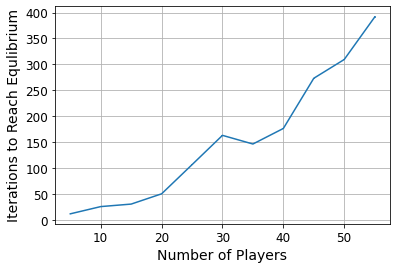

In [9]:
# Plot simulation results
steps_to_converge_mean = np.mean(steps_to_converge, axis=1)
steps_to_converge_error = 1.96 * np.std(steps_to_converge, axis=1) / np.sqrt(num_trials)
plt.errorbar(N_vals, steps_to_converge_mean, yerr=steps_to_converge_error)
plt.xlabel("Number of Players", fontsize=14)
plt.ylabel("Iterations to Reach Equlibrium", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.savefig("output/uniV2_scenario1", dpi=300)

### Scenario 3

In [10]:
# Define the simulation parameters
T=200
num_trials = 100
N = 10

In [11]:
N_vals = np.arange(5, 40, 5)
strategy_delta = np.zeros((N_vals.shape[0], num_trials))
profit_delta = np.zeros((N_vals.shape[0], num_trials))

In [12]:
# Run the simulation
for (index, N) in enumerate(N_vals):
    unique_equilibrium = uniV2_equilibrium(N)
    
    budget_constraint = np.zeros(N)
    budget_constraint[0] = 1000000
    budget_constraint[1:] = np.random.uniform(size=N-1) * unique_equilibrium
    
    for trial in range(num_trials):
        x_init = np.random.uniform(size=N) * budget_constraint
        x_init[0] = np.random.uniform() * W/N
        
        sim_hist = np.zeros((N, T+1))
        sim_hist[:, 0] = x_init
        current_strat = x_init.copy()
        for iteration in range(T):
            for i in range(N):
                new_strat = best_response_uniV2(i, current_strat)
                if new_strat > budget_constraint[i]:
                    min_bound_payoff = payoff_function_uniV2(0,
                                                             np.sum(current_strat)-current_strat[i])
                    max_bound_payoff = payoff_function_uniV2(budget_constraint[i],
                                                             np.sum(current_strat)-current_strat[i])
                    if min_bound_payoff < max_bound_payoff:
                        new_strat = budget_constraint[i]
                    else:
                        new_strat = 0
                current_strat[i] = new_strat
                sim_hist[i, iteration+1] = new_strat
                
        whale_strat = current_strat[0]
        whale_payoff = payoff_function_uniV2(whale_strat, np.sum(current_strat[1:]))
        base_payoff = payoff_function_uniV2(unique_equilibrium, unique_equilibrium * (N-1))
        
        strategy_delta[index, trial] = (whale_strat - unique_equilibrium) / unique_equilibrium
        profit_delta[index, trial] = (whale_payoff - base_payoff) / base_payoff

# Plot simulation results
        
strategy_mean = np.mean(strategy_delta, axis=1)
strategy_error = 1.96 * np.std(strategy_delta, axis=1) / np.sqrt(num_trials)
profit_mean = np.mean(profit_delta, axis=1)
profit_error = 1.96 * np.std(profit_delta, axis=1) / np.sqrt(num_trials)

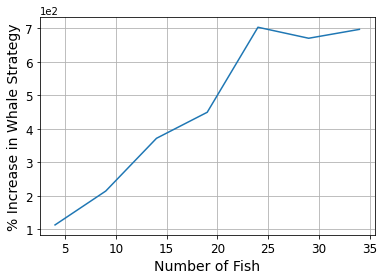

In [13]:
plt.errorbar(N_vals-1, strategy_mean * 100, yerr=strategy_error * 100)
plt.xlabel("Number of Fish", fontsize=14)
plt.ylabel("% Increase in Whale Strategy", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ticklabel_format(style='sci', axis='y', scilimits=[0, 1])
plt.grid()
plt.savefig("output/uniV2_scenario3strat", dpi=300)

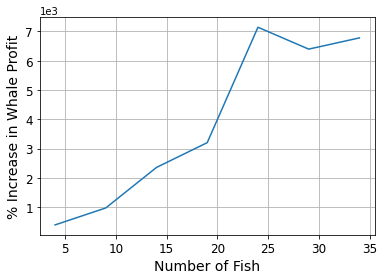

In [14]:
plt.errorbar(N_vals-1, profit_mean * 100, yerr=profit_error * 100)
plt.xlabel("Number of Fish", fontsize=14)
plt.ylabel("% Increase in Whale Profit", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ticklabel_format(style='sci', axis='y', scilimits=[0, 1])
plt.grid()
plt.savefig("output/uniV2_scenario3profit", dpi=300)

### Price of Anarchy

In [15]:
N_vals = np.arange(5, 50, 1)
optimal_payoff_uniV2 = np.zeros(N_vals.shape[0])
equilibrium_payoff_uniV2 = np.zeros(N_vals.shape[0])

In [16]:
for (index, N) in enumerate(N_vals):
    opt_strat = np.sqrt(GAMMA * RESERVES[1] * RESERVES[0] / EXTERNAL_PRICE)
    opt_strat = (opt_strat - RESERVES[0]) / GAMMA / N
    optimal_payoff_uniV2[index] = payoff_function_uniV2(opt_strat,
                                                  opt_strat * (N-1))
    equilibrium_strat = uniV2_equilibrium(N)
    equilibrium_payoff_uniV2[index] = payoff_function_uniV2(equilibrium_strat,
                                                      equilibrium_strat * (N-1))

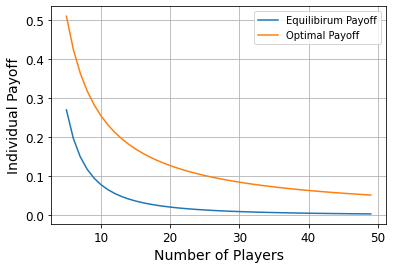

In [17]:
plt.plot(N_vals, equilibrium_payoff_uniV2, label="Equilibirum Payoff")
plt.plot(N_vals, optimal_payoff_uniV2, label="Optimal Payoff")
plt.xlabel("Number of Players", fontsize=14)
plt.ylabel("Individual Payoff", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.legend()
plt.savefig("output/uniV2_anarchy", dpi=300)

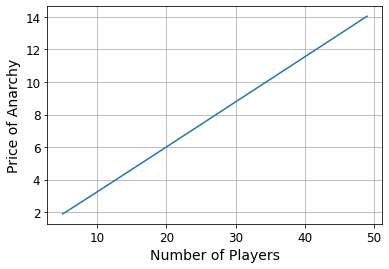

In [18]:
plt.plot(N_vals, optimal_payoff_uniV2/equilibrium_payoff_uniV2)
plt.xlabel("Number of Players", fontsize=14)
plt.ylabel("Price of Anarchy", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.savefig("output/uniV2_anarchyRatio", dpi=300)

## Toy Forward Exchange Function

In [19]:
# Compute the best response for the toy forward exchange function
# introduced in the paper
def compute_best_response(index, x_t, beta, gamma, min_bound, max_bound,
                          termination_threshold=1e-4):
    
    min_bound = np.max([min_bound, 0])
    max_bound = np.min([max_bound, (1/gamma)**(1/(1-beta))])
        
    z = np.sum(x_t)-x_t[index]
    
    if z**(1-beta) >= 1/gamma:
        return 0
    
    low_zero = 1
    high_zero = 1
    low_zero_val = pseudo_gradient_function(low_zero, z=z,
                                            beta=beta, gamma=gamma)
    high_zero_val = low_zero_val
    
    while low_zero_val > 0:
        low_zero /= 2
        low_zero_val = pseudo_gradient_function(low_zero, z=z,
                                                beta=beta, gamma=gamma)
    
    while high_zero_val < 0:
        high_zero *= 2
        high_zero_val = pseudo_gradient_function(high_zero, z=z,
                                                 beta=beta, gamma=gamma)
    
    while high_zero - low_zero > termination_threshold:
        mid_zero = (low_zero + high_zero) / 2
        mid_zero_val = pseudo_gradient_function(mid_zero, z=z,
                                                beta=beta, gamma=gamma)
        if mid_zero_val > 0:
            high_zero = mid_zero
        else:
            low_zero = mid_zero
    
    if (low_zero >= min_bound) & (low_zero <= max_bound):
        return low_zero
    else:
        min_bound_payoff = payoff_function(min_bound, z=z,
                                           beta=beta, gamma=gamma)
        max_bound_payoff = payoff_function(max_bound, z=z,
                                           beta=beta, gamma=gamma)
        if min_bound_payoff < max_bound_payoff:
            return max_bound
        else:
            return min_bound

def pseudo_gradient_function(x, z, beta, gamma):
    
    value = gamma * (x+z)**(2-beta)-(beta*x+z)
    return value
        
# Compute the toy forward exchange function payoff
def payoff_function(x, z, beta, gamma):
    value = x/(x+z) * ((x+z)**beta-gamma*(x+z))
    return value

In [20]:
# Define toy function parameters
BETA = 0.5
GAMMA = 0.05;

## Scenario 1

In [21]:
W = (1/GAMMA)**(1/(1-BETA))
Z = (BETA/GAMMA)**(1/(1-BETA))

In [22]:
# Define the simulation parameters
T = 500
num_trials = 100

In [23]:
N_vals = np.arange(5, 40, 5)
steps_to_converge = np.zeros((N_vals.shape[0], num_trials))

In [24]:
# Run the simulation
for (index, N) in enumerate(N_vals):
    y_star = ((N-1+BETA) / (GAMMA*N))**(1/(1-BETA))
    unique_equilibrium = y_star/N
        
    for trial in range(num_trials):
        x_init = np.random.uniform(size=N) * W/N
        
        sim_hist = np.zeros((N, T+1))
        sim_hist[:, 0] = x_init
        current_strat = x_init.copy()
        for iteration in range(T):
            for i in range(N):
                new_strat = compute_best_response(i, current_strat,
                                                  BETA, GAMMA, 0, W)
                current_strat[i] = new_strat
                sim_hist[i, iteration+1] = new_strat

            # Verify if the termination condition has been met
            if np.linalg.norm(np.round(current_strat, 1)-np.round(unique_equilibrium ,1)) == 0:
                steps_to_converge[index, trial] = iteration + 1
                break

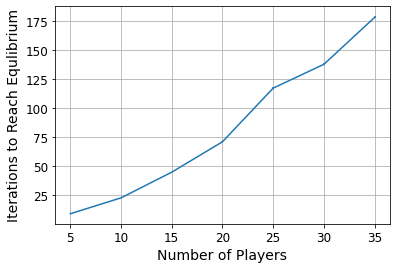

In [25]:
# Plot simulation results

steps_to_converge_mean = np.mean(steps_to_converge, axis=1)
steps_to_converge_error = 1.96 * np.std(steps_to_converge, axis=1) / np.sqrt(num_trials)
plt.errorbar(N_vals, steps_to_converge_mean, yerr=steps_to_converge_error)
plt.xlabel("Number of Players", fontsize=14)
plt.ylabel("Iterations to Reach Equlibrium", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.savefig("output/penumbra_scenario1", dpi=300)

## Scenario 2

### a) Updates Subject to $\vert x_i^t - x_i^{t-1} \vert \leq \delta$

In [26]:
# Define the simulation parameters
T=500
num_trials = 100
N = 10

In [27]:
y_star = ((N-1+BETA) / (GAMMA*N))**(1/(1-BETA))
unique_equilibrium = y_star/N

In [28]:
DELTA_vals = np.linspace(0.5, unique_equilibrium, 40)
steps_to_converge = np.zeros((DELTA_vals.shape[0], num_trials))

In [29]:
# Run the simulation
for (index, DELTA) in enumerate(DELTA_vals):        
    for trial in range(num_trials):
        x_init = np.random.uniform(size=N) * W/N
        
        sim_hist = np.zeros((N, T+1))
        sim_hist[:, 0] = x_init
        current_strat = x_init.copy()
        for iteration in range(T):
            for i in range(N):
                new_strat = compute_best_response(i, current_strat,
                                                  BETA, GAMMA, current_strat[i]-DELTA,
                                                  current_strat[i]+DELTA)
                current_strat[i] = new_strat
                sim_hist[i, iteration+1] = new_strat
            
            # Verify if the termination condition has been met
            if np.linalg.norm(np.round(current_strat, 1)-np.round(unique_equilibrium, 1)) == 0:
                steps_to_converge[index, trial] = iteration + 1
                break

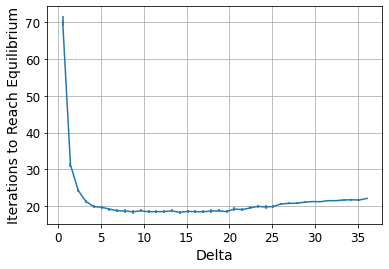

In [30]:
# Plot simulation results
steps_to_converge_mean = np.mean(steps_to_converge, axis=1)
steps_to_converge_error = 1.96 * np.std(steps_to_converge, axis=1) / np.sqrt(num_trials)
plt.errorbar(DELTA_vals, steps_to_converge_mean, yerr=steps_to_converge_error)
plt.xlabel("Delta", fontsize=14)
plt.ylabel("Iterations to Reach Equilibrium", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.savefig("output/penumbra_scenario2a", dpi=300)

## Scenario 3

In [31]:
# Define the simulation parameters
T=200
num_trials = 100
N = 10

In [32]:
N_vals = np.arange(5, 40, 5)
strategy_delta = np.zeros((N_vals.shape[0], num_trials))
profit_delta = np.zeros((N_vals.shape[0], num_trials))

In [33]:
# Run the simulation
for (index, N) in enumerate(N_vals):
    y_star = ((N-1+BETA) / (GAMMA*N))**(1/(1-BETA))
    unique_equilibrium = y_star/N
    
    budget_constraint = np.zeros(N)
    budget_constraint[0] = 1000000
    budget_constraint[1:] = np.random.uniform(size=N-1) * unique_equilibrium
    
    for trial in range(num_trials):
        x_init = np.random.uniform(size=N) * budget_constraint
        x_init[0] = np.random.uniform() * W/N
        
        sim_hist = np.zeros((N, T+1))
        sim_hist[:, 0] = x_init
        current_strat = x_init.copy()
        for iteration in range(T):
            for i in range(N):
                new_strat = compute_best_response(i, current_strat,
                                                  BETA, GAMMA, 0, budget_constraint[i])
                current_strat[i] = new_strat
                sim_hist[i, iteration+1] = new_strat
                
        whale_strat = current_strat[0]
        whale_payoff = payoff_function(whale_strat, np.sum(current_strat[1:]), BETA, GAMMA)
        base_payoff = payoff_function(unique_equilibrium, unique_equilibrium * (N-1), BETA, GAMMA)
        
        strategy_delta[index, trial] = (whale_strat - unique_equilibrium) / unique_equilibrium
        profit_delta[index, trial] = (whale_payoff - base_payoff) / base_payoff

# Plot simulation results
strategy_mean = np.mean(strategy_delta, axis=1)
strategy_error = 1.96 * np.std(strategy_delta, axis=1) / np.sqrt(num_trials)
profit_mean = np.mean(profit_delta, axis=1)
profit_error = 1.96 * np.std(profit_delta, axis=1) / np.sqrt(num_trials)

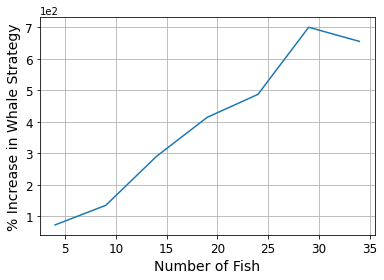

In [34]:
plt.errorbar(N_vals-1, strategy_mean * 100, yerr=strategy_error * 100)
plt.xlabel("Number of Fish", fontsize=14)
plt.ylabel("% Increase in Whale Strategy", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ticklabel_format(style='sci', axis='y', scilimits=[0, 1])
plt.grid()
plt.savefig("output/penumbra_scenario3strat", dpi=300)

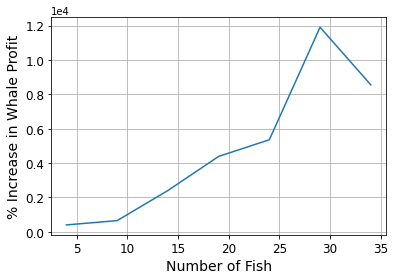

In [35]:
plt.errorbar(N_vals-1, profit_mean * 100, yerr=profit_error * 100)
plt.xlabel("Number of Fish", fontsize=14)
plt.ylabel("% Increase in Whale Profit", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ticklabel_format(style='sci', axis='y', scilimits=[0, 1])
plt.grid()
plt.savefig("output/penumbra_scenario3profit", dpi=300)

# Price of Anarchy

In [36]:
def compute_optimal_payoff(n, beta=BETA, gamma=GAMMA):
    exponent = beta / (1-beta)
    return (beta/gamma)**exponent * (1-beta)/n

In [37]:
def compute_equilibrium_payoff(n, beta=BETA, gamma=GAMMA):
    exponent = beta / (1-beta)
    temp = (beta+n-1)/(gamma*n)
    return temp**exponent*(1-beta)/(n**2)

In [38]:
N_vals = np.arange(5, 50, 1)
optimal_payoff = np.zeros(N_vals.shape[0])
equilibrium_payoff = np.zeros(N_vals.shape[0])

In [39]:
for (index, N) in enumerate(N_vals):
    optimal_payoff[index] = compute_optimal_payoff(N)
    equilibrium_payoff[index] = compute_equilibrium_payoff(N)

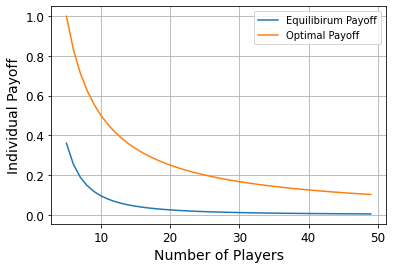

In [40]:
plt.plot(N_vals, equilibrium_payoff, label="Equilibirum Payoff")
plt.plot(N_vals, optimal_payoff, label="Optimal Payoff")
plt.xlabel("Number of Players", fontsize=14)
plt.ylabel("Individual Payoff", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.legend()
plt.savefig("output/penumbra_anarchy", dpi=300)

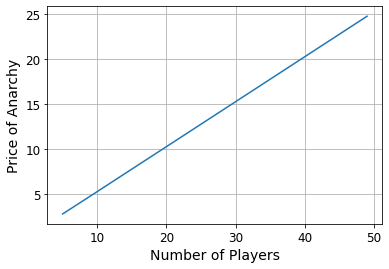

In [41]:
plt.plot(N_vals, optimal_payoff/equilibrium_payoff)
plt.xlabel("Number of Players", fontsize=14)
plt.ylabel("Price of Anarchy", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.savefig("output/penumbra_anarchyRatio", dpi=300)